# Source-filter speech model


Outline of the notebook:

###  <a href='#1'>1. Introduction</a> 

Short introduction to speech signals and the source-filter model.

###  <a href='#2'>2. Theoretical part</a> 

**Objective**: Understand the fundamentals of the source-filter speech model based on an autoregressive (AR) modeling (also called linear prediction), and how to estimate its parameters by solving Yule-Walker equations.

###  <a href='#3'>3. Practical work</a> 

* #### <a href='#3.1'> 3.1 Visualization</a> 

    **Objective**: Visualize a short stationary speech signal (a vowel) in the time and frequency domains. Understand the difference between the pitch and the formants.

* #### <a href='#3.2'>3.2 AR model parameters estimation</a> 

   **Objective**: Fit an AR model on the vowel signal, solving the Yule-Walker equations.

* #### <a href='#3.3'>3.3 Spectral envelope</a> 

    **Objective**: Compute and observe the spectral envelope, which characterizes the resonances in the vocal tract.
    
* #### <a href='#3.4'>3.4 Residual</a> 

    **Objective**: Compute and observe the residual of the linear prediction, which corresponds to the speech source signal.

* #### <a href='#3.5'>3.5 Synthesis</a> 

    **Objective**: Synthesize voiced and unvoiced speech signals by linear prediction.
    
#### <a href='#bonus'>Bonus: Short-term speech analysis/synthesis</a> 

**Objective**: Extend the previous work to deal with arbitrary-length speech signals.

#### <a href='#appendix'>Appendix</a> 

Technical signal processing details.


<a id='1'></a>


## 1. Introduction

### 1.1 Generalities

In telephony, the  sampling rate of speech signals is chosen to ensure the intelligibility of the message and allow for speaker indentification. These conditions are fullfiled by keeping the frequency band [0 - 4] kHz, known as the voice band. Therefore, we choose a sampling frequency of 8 kHz. 

### 1.2 Speech sounds

We distinguish two types of speech sounds:

1. Voiced sounds, with a quasi-periodic waveform. Vowels are a perfect example of voiced sounds. 
2. Unvoiced sounds, with a noise-like waveform. 

Vowels are typically longer than consonants. There exist multiple types of consonants: 

- nasals which are voiced, such as /m/ or /n/;
- fricatives which can be voiced in /v/, /z/, /j/ or unvoiced in /f/, /s/, /ch/;
- plosives which can be voiced  in /b/, /d/, /g/ or unvoiced in /p/, /t/, /k/;
- liquids which are voiced, such as /l/ or /r/.

### 1.3 Source-filter speech model

<img src="./figures/block_diagram.png" width="500px" align="center">

One of the most important concepts for characterizing the structure of speech signals is deduced from the source-filter model proposed by Fant in 1970. In this model the speech signal is seen as a sound source that has undergone spectral modifications according to the shape of the vocal tract, which acts as an acoustic filter. As we have seen, a vocal source can be either voiced, when there is vibration of the vocal folds, or unvoiced, when a turbulent noise is created at a constriction, or following a sudden relaxation of an occlusion in the vocal tract.

The two types of speech sounds, voiced and unvoiced, can be modeled as the output of an all-pole (infinite impulse response) linear filter, whose order (number of coefficients) ranges between 10 and 20, and whose input is:

- a white noise signal for unvoiced sounds;
- a periodic pulse train for voiced sounds.

The pulse train associated with voiced sounds corresponds to the sequence of openings and closings of the glottis (the space between the vocal folds), openings being much longer that closings. During the closing phases, the sudden reduction in the air flow causes a brief pulse. The fundamental frequency of this periodic signal is called the pitch. 

<img src="./figures/vocal_fold_signal.png" width="400px" align="center">

<img src="./figures/vocal_fold_signal_zoom.png" width="550px" align="center">

For a man, the pitch varies between 90 and 270 Hz, for a woman it varies between 120 and 360 Hz, and for a child between 200 and 600 Hz. For a given speaker, the pitch changes through the conversation, it is part of the prosody. 

The vocal tract acts as a set of resonators, and gives rise to resonances at specific frequencies which are called the formant frequencies.

<img src="./figures/formants.png" width="650px" align="center">

Credits for Figures 4.33, 4.34 and 4.38: David Howard, Jamie Angus. Acoustics and Psychoacoustics, Fourth Edition (2009, Focal Press).


<a id='2'></a>
## 2. Theoretical part

### 2.1 Autoregressive model

The **source-filter model** can be formalized mathematically with the following **autoregressive model** of order $P$:

$$ X(t) + \sum_{i=1}^P a_i X(t-i) = W(t), \qquad (1) $$

where $W(t)$ is a white Gaussian noise of variance $\sigma_w^2$ and the polynomial $A(z) = 1 + \sum_{i=1}^P a_p z^{-p} \neq 0$ for $|z|>1$.

It can be shown that the unique solution to (1) is given by:

$$ X(t) = \sum_{k=0}^{+\infty} h_k W(t-k) = [W \star h](t), \qquad (2)$$

where $\star$ denotes the convolution operator. $X(t)$ corresponds to an **infinite impulse response filtering** of $W(t)$, whose transfer function is given in the Z-transform domain by 

$$\displaystyle H(z) = \frac{1}{A(z)} = \sum_{k=0}^{+\infty} h_k z^{-k}.$$ 

The coefficients $\{h_k\}_{k=0}^{+\infty}$ are the coefficients of the impulse response. This transfer function exhibits resonances at the zeros of the polynomial $A(z)$, which are called the poles of the filter.

**For speech modeling, $W(t)$ represents the unvoiced source signal, $H(z)$ the transfer function of the vocal tract filter, and $X(t)$ the resulting speech signal. In practice, we assume that for voiced speech sounds, only the source signal $W(t)$ changes, and it corresponds to a periodic pulse train. However, for the theoretical analysis, we assume that $W(t)$ is a white Gaussian noise.**

It is also possible to interpret this AR speech model in terms of **linear prediction**. Equation (1) rewrites as

$$ X(t) = \hat{X}(t) + W(t),$$

where $\hat{X}(t) = - \sum_{i=1}^P a_i X(t-i)$ is the linear prediction of $X(t)$, computed from the $P$ previous coefficients. 

LPC10 is a speech coding standard developed in the 70's by the USA government. It is based on this exact AR speech model. At the encoder, we compute P=10 AR coefficients, the energy of the source signal, and the pitch of the voice if the signal is voiced. These parametrs are then sent through the communication channel, and used at the decoder to reconstruct the speech signal by linear prediction, using a white noise or a periodic pulse train source signal.

This is what you are going to implement in the rest of this notebook. But before, let's briefly discuss how to estimate the AR model parameters. This is done by solving the so-called Yule-Walker equations, which from the linear prediction perspective is equivalent to minimizing the expected squared error $\mathbb{E}[(X(t) - \hat{X}(t))^2].$

### 2.2 Estimating the model parameters by solving Yule-Walker equations

We are interested in estimating the AR model parameters (the $P$ AR cofficients and the noise variance) from a quasi-stationary portion of speech signal, whose $T$ samples are denoted by $x(0),..., x(T-1)$.

Using the properties of the AR random process defined in (1), we can show (the interested reader is referred to the appendix) that the following **Yule-Walker equations** hold:

\begin{equation}
\begin{pmatrix}
\hat{R}(0) & \hat{R}(1) & \cdots & \hat{R}(P) \\
\hat{R}(1) & \hat{R}(0) & \cdots & \hat{R}(P-1) \\
\vdots  & \vdots  & \ddots & \vdots  \\
\hat{R}(P) & \hat{R}(P-1) & \cdots & \hat{R}(0)
\end{pmatrix}
\begin{pmatrix}
1 \\
a_1 \\
\vdots \\
a_P
\end{pmatrix}=
\begin{pmatrix}
\sigma_w^2 \\
0 \\
\vdots \\
0
\end{pmatrix},
\end{equation}

where $\hat{R}(k)$ is the empirical autocovariance function defined by

$$ \hat{R}(k) = \frac{1}{T} \sum_{t=0}^{T-1-k} x(t) x(t+k), \qquad k \ge 0. $$

For $k < 0$, $\hat{R}(k) = \hat{R}(-k)$.

We have $P+1$ equations for $P+1$ unknowns, we can therefore solve this system to estimate the model parameters. 

**In summary, we estimate the model parameters by computing the empirical autocovariance function of the signal and then solving the Yule-Walker equations.**

### 2.3 Frequency-domain interpretation of the AR speech model

The time-domain AR model in (1) leads to the following interpretation in the frequency domain, or more precisely in the domain of the discrete-time Fourier transform (DTFT):

$$ \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2 = \frac{1}{ \Big| 1 + \sum_{p=1}^P \hat{a}_p  e^{-j 2 \pi \nu p} \Big|^2} \times \hat{\sigma}_w ^2, $$

where $\hat{a}_p$ and $\hat{\sigma}_w ^2$ are estimates of the AR model parameters, obtained by solving the Yule-Walker equations.

The left-hand side is simply the (scaled) **power spectrum of the speech signal**. More precisely, it's an estimate of the power spectral density (PSD) of the random process $X(t)$ that is called the periodogram, but you do not need to remember this.

The right-hand side is the product of two terms:

- $\displaystyle \frac{1}{ \Big| 1 + \sum_{p=1}^P \hat{a}_p  e^{-j 2 \pi \nu p} \Big|^2}$ is called the **spectral envelope**. It corresponds to the frequency response of the all-pole filter in the AR model and it accounts for the **resonances in the vocal tract**. 

- $\hat{\sigma}_w ^2$ is the **power spectrum of the source signal** (actually also an estimate of the source PSD). We say that the source is **white**, because its PSD is constant. This precisely comes from the fact that we assumes $W(t)$ is a white Gaussian noise.

**In summary, the spectrum of the speech signal is equal to the multiplication of (i) the flat spectrum of the source signal, and (ii) the frequency response of the all-pole filter which models the resonances (i.e. formants) in the vocal tract.**

For more technical details, the interested reader is referred to the appendix.

<a id='3'></a>
## 3. Practical work


In [1]:
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display

%matplotlib inline

Let's first load a speech signal.

8000


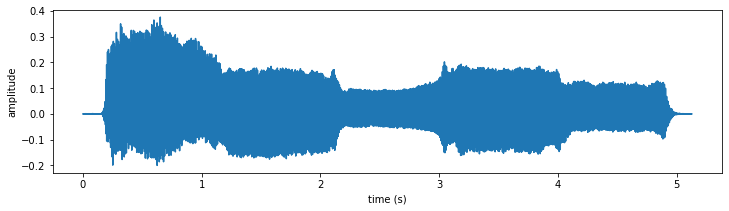

In [2]:
x_all, fs = sf.read('./data/aeiou_8k.wav')

print(fs)

T_all = x_all.shape[0]
time = np.arange(T_all)/fs

plt.figure(figsize=(12,3))
plt.plot(time, x_all)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

ipd.Audio(x_all, rate=fs) 

We use the toolbox [librosa](https://librosa.github.io/librosa/) to compute the power spectrogram.

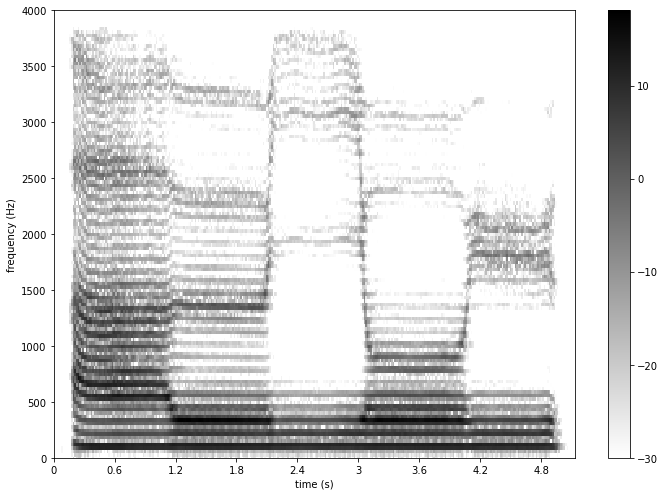

In [3]:
wlen_sec=32e-3
hop_percent=.5
wlen = int(wlen_sec*fs) # window length of 64 ms
wlen = int(np.power(2, np.ceil(np.log2(wlen)))) # next power of 2
nfft = wlen
hop = int(hop_percent*wlen) # hop size
win = np.sin(np.arange(.5,wlen-.5+1)/wlen*np.pi); # sine analysis window

X = librosa.stft(x_all, n_fft=nfft, hop_length=hop, win_length=wlen, window=win) # STFT

plt.figure(figsize=(10,7))
librosa.display.specshow(librosa.power_to_db(np.abs(X)**2), sr=fs, hop_length=hop, x_axis='time', y_axis='hz')

plt.set_cmap('gray_r')
plt.colorbar()
plt.clim(vmin=-30)

plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')
plt.tight_layout()

Vowels in the previous signal are approximately 0.5-second long, and they start at:

- 0.25 second for /a/
- 1.2 second for /e/
- 2.2 second for /i/
- 3.1 second for /o/
- 4.1 second for /u/

<a id='3.1'></a>
### 3.1 - Visualization

In the following cell, we

- extract a single vowel (i.e. a stationary portion) from the signal ```x_all```. 
- listen to the isolated vowel.
- visualize the waveform and the power spetrum in dB (discarding the redundant part).

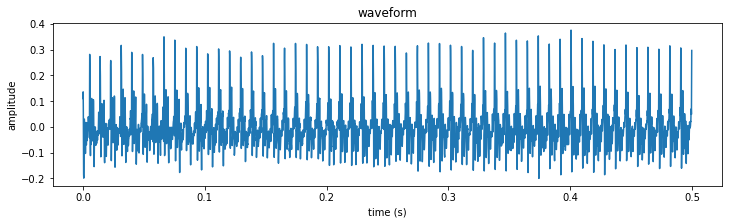

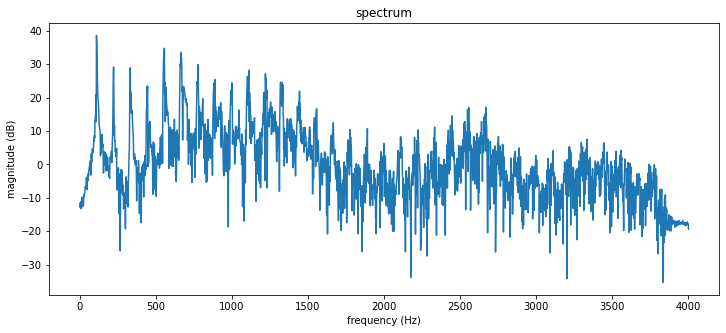

In [4]:
t0vec = [int(0.25*fs), int(1.2*fs), int(2.2*fs), int(3.1*fs), int(4.1*fs)]

ind_vowel = 0

x = x_all[t0vec[ind_vowel]:t0vec[ind_vowel]+int(0.5*fs)]
T = x.shape[0]

time = np.arange(T)/fs

plt.figure(figsize=(12,3))
plt.plot(time, x)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.title('waveform')

X = np.fft.fft(x)[:T//2+1]
X_spec = np.abs(X)**2
X_spec_db = 10*np.log10(X_spec)

freq  = np.arange(0, T//2+1)*fs/T

plt.figure(figsize=(12,5))
plt.plot(freq, X_spec_db)
plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude (dB)')
plt.title('spectrum')

ipd.Audio(x, rate=fs) 

From the spectrum, we clearly identify the pitch of the voice (the fundamental frequency, associated with the first peak in the spectrum) and the formants (the frequencies of the resonances). You can change the index of the vowel taken from ```x_all```, the fundamental frequency should remain the same and the formants should change.

**Feel free to load in the variable ```x``` a recording of your voice uttering a vowel.** The signal should have a sampling rate of 8 kHz, you can use [librosa.resample](https://librosa.org/doc/0.9.1/generated/librosa.resample.html?highlight=resample#librosa.resample) to resample a signal.

<a id='3.2'></a>
### 3.2 - AR model parameters estimation

In the following ```LPC``` function, we solve Yule-Walker equations in order to estimate the parameters of the autoregressive speech model of order P.

- [```sp.linalg.toeplitz```](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.linalg.toeplitz.html) computes the covariance matrix, which is Toeplitz
- [```np.linalg.inv```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) computes the inverse of a matrix
- ```@``` multiplies two matrices
- [```np.concatenate```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) concatenates two numpy arrays

In [5]:
def LPC(x, P):
    
    T = x.shape[0]
    
    r = np.zeros(P+1)
    
    for i in np.arange(P+1):
        
        x1 = x[i:T]
        x2 = x[:T-i]
        r[i] = 1/T*np.sum(x1*x2)
        
    R = sp.linalg.toeplitz(r[:P])
    a = -np.linalg.inv(R)@r[1:]
    sigma2 = np.sum(r * np.concatenate([np.array([1.]), a]))

    return a, sigma2

We call this function to estimate the parameters of an AR model of order $P=16$ on the previous vowel signal.

In [6]:
P = 16
a, sigma2 = LPC(x, P)
print(a)
print(sigma2)

[-1.44550407  0.86803147 -0.39767076  0.61614579 -0.61719995  0.14811821
 -0.13786562  0.62180548 -0.73189077  0.3978209  -0.28026295  0.14785132
 -0.06780316  0.02417694 -0.11235847  0.11933363]
0.0009718009143970598


<a id='3.3'></a>

### 3.3 - Spectral envelope (Exercise)


- Compute and plot the periodogram of the signal defined by

$$ \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2 $$

- Compute and plot on the same figure the scaled spectral envelope defined by

  $$ \frac{\hat{\sigma}_w ^2}{ \Big| 1 + \sum_{p=1}^P \hat{a}_p  e^{-j 2 \pi \nu p} \Big|^2},$$

  where $\hat{a}_p$ and $\hat{\sigma}_w ^2$ are the estimates of the AR model parameters. Note that the denominator of the spectral envelop involves the DTFT of the sequence $\{1, a_1, ..., a_P\}.$
  
  In practice, you will compute the DFT of order $F = T$ (i.e. $\nu = f/F$ with $f\in \{0,...,F-1\}$, using ```np.fft.fft```.
  
  

- What do you observe?

Text(0, 0.5, 'magnitude (dB)')

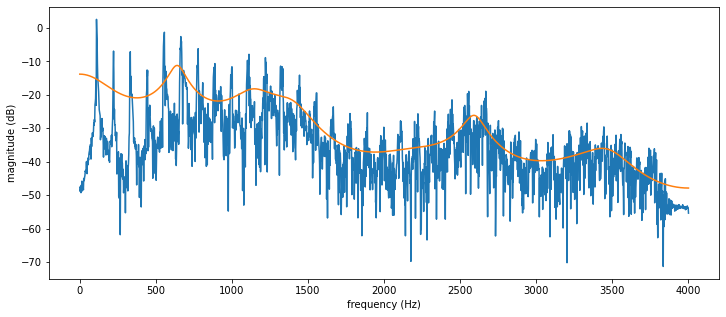

In [7]:
perio_x = np.abs(X)**2/T

perio_x_db = 10*np.log10(perio_x)

den = np.abs( np.fft.fft( np.concatenate([np.array([1.]), a]), T) )[:T//2+1]

spec_env_db = 10*np.log10(sigma2) - 20*np.log10(den)


freq  = np.arange(0, T//2+1)*fs/T

plt.figure(figsize=(12,5))
plt.plot(freq, perio_x_db)
plt.plot(freq, spec_env_db)
plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude (dB)')

<a id='3.4'></a>

### 3.4 - Residual (Exercise)

Complete the next cell to compute the residual $e(t) = x(t) - \hat{x}(t)$ with $\hat{x}(t) = - \sum_{i=1}^P a_i x(t-i)$.

In [8]:
residual = np.zeros(T)
x_pred = np.zeros(P)
for t in np.arange(T):
    residual[t] = x[t] + np.sum(a * x_pred)
    x_pred[1:] = x_pred[:P-1]
    x_pred[0] = x[t]

In the next cells, we visualize the waveform, the spectrum and listen to the residual speech signal.

Text(0, 0.5, 'amplitude')

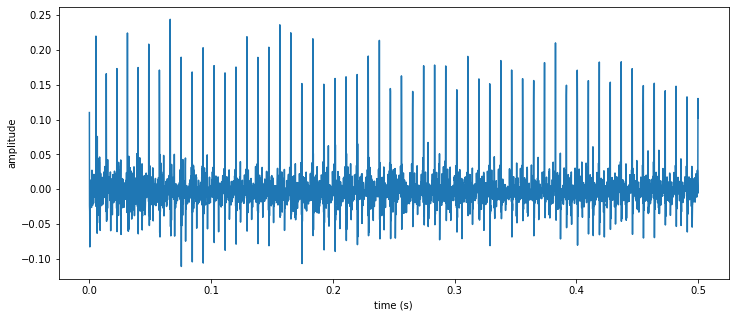

In [9]:
time = np.arange(T)/fs

plt.figure(figsize=(12,5))
plt.plot(time, residual)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

Text(0, 0.5, 'magnitude (dB)')

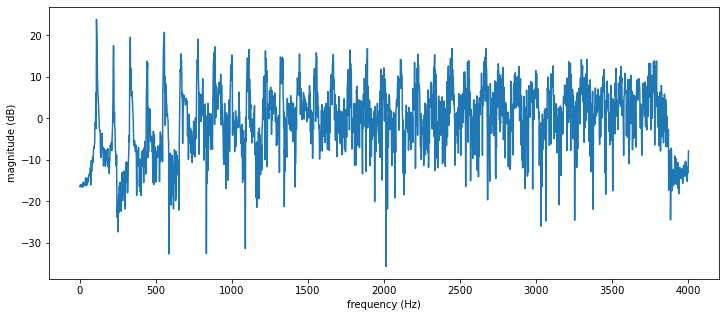

In [10]:
spec_res = np.abs(np.fft.fft(residual)[:T//2+1])**2
spec_res_db = 10*np.log10(spec_res)

freq  = np.arange(0, T//2+1)*fs/T

plt.figure(figsize=(12,5))
plt.plot(freq, spec_res_db)
plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude (dB)')

In [11]:
ipd.Audio(residual, rate=fs) 

How different is the spectrum of the residual from the spectrum of the original signal?

Listen to the residuals obtained from different vowels, what do you observe?

<a id='3.5'></a>
### 3.5 - Synthesis (Exercise)

Complete the next cell to generate recursively the speech signal according to the AR model:

 $$ x(t) = \hat{x}(t) + w(t), \qquad \hat{x}(t) = - \sum_{i=1}^P a_i x(t-i), $$
 
when the source $w(t)$ is either:

- the residual signal that you computed before,
- a white Gaussian noise of variance $\sigma_w^2$, 
- a periodic pulse train.

In [12]:
source = 'unvoiced' # 'residual', 'unvoiced', or "voiced"
f0 = 120
T0 = int(1/f0*fs)

if source=='voiced':
    w = np.zeros(T)
    w[0:T:T0] = np.sqrt(sigma2)
elif source=='unvoiced':
    w = np.sqrt(sigma2)*np.random.randn(T)
elif source=='residual':
    w = residual  
    
x_gen = np.zeros(T)
x_gen_pred =  np.zeros(P)

for t in np.arange(T):
    x_gen[t] = w[t] - np.sum(a * x_gen_pred)
    x_gen_pred[1:] = x_gen_pred[:P-1]
    x_gen_pred[0] = x_gen[t]

In the following cells, we visualize the waveform, the spectrum and listen to the synthesized speech signals. 

Compare what you obtain with different types of source signals (unvoiced, voiced or residual).

Text(0, 0.5, 'amplitude')

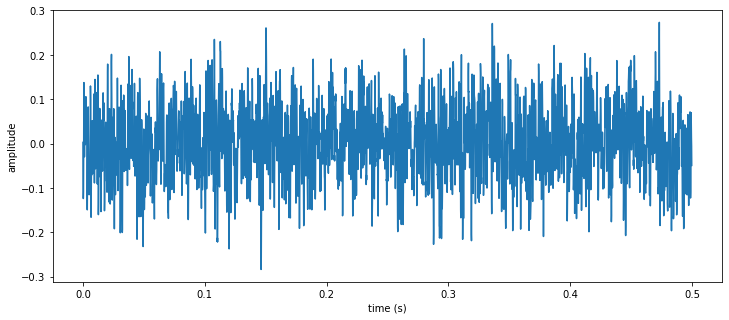

In [13]:
time = np.arange(T)/fs

plt.figure(figsize=(12,5))
plt.plot(time, x_gen)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

Text(0, 0.5, 'magnitude (dB)')

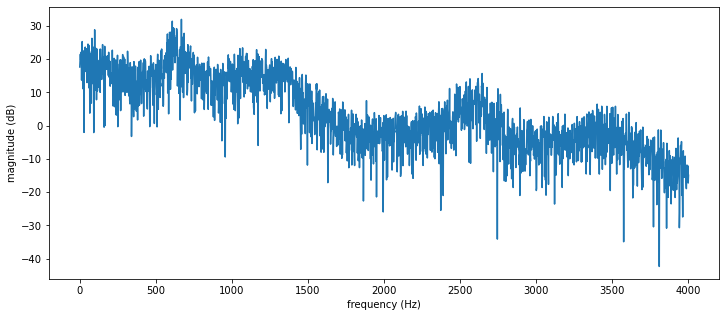

In [14]:
spec_x_gen = np.abs(np.fft.fft(x_gen)[:T//2+1])**2
spec_x_gen_db = 10*np.log10(spec_x_gen)

freq  = np.arange(0, T//2+1)*fs/T

plt.figure(figsize=(12,5))
plt.plot(freq, spec_x_gen_db)
plt.xlabel('frequency (Hz)')
plt.ylabel('magnitude (dB)')

In [15]:
ipd.Audio(x_gen, rate=fs) 

<a id='bonus'></a>
## Bonus: Short-term analysis/synthesis (exercise)

In the experiments before, we analysed and synthesized a short stationary speech signal. However, in practice we have to deal with non-stationary speech signals of arbitrary length. Therefore, we have to process the signal on short overlapping frames where we can assume that the signal is stationary, as in the short-time Fourier transform.

This is what is (almost) implemented in the rest of the notebook. Complete and run the cells below, and play with the ```voiced``` and ```f0```  variables to make the synthesized speech sound like a whispered voice or a robot's voice. **Feel free to use a recording of your own voice, or any other speech signal**.

In [16]:
x_all, fs_x = sf.read('./data/voice_man_1.wav')

if fs_x != fs:
    # resample to 8 kHz, if necessary
    ratio = float(fs) / float(fs_x)
    n_samples = int(np.ceil(x_all.shape[-1] * ratio))
    x_all = sp.signal.resample(x_all, n_samples, axis=-1)
    
ipd.Audio(x_all, rate=fs) 

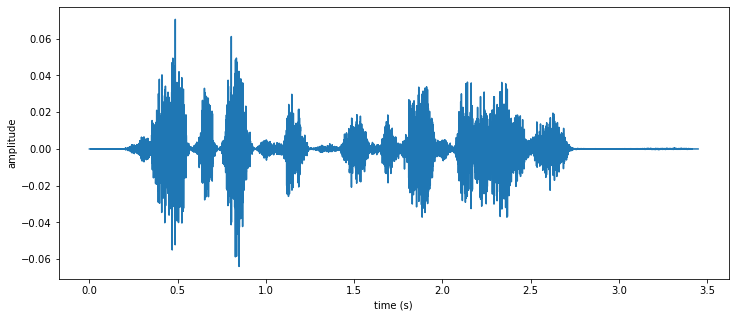

In [17]:
fs = 8000
L = 240 # window length (30 ms @ 8 kHz)
H = 120 # hop size
P = 16 # order of the AR model

voiced = False # boolean indicating if voice should be voiced or not
f0 = 50 # fundamental frequency in Hz (if voiced)
T0 = int(1/f0*fs) # associated period

T = x_all.shape[0]

N = int(np.fix( (T-L)/H)) # number of frames

win = np.sin(np.arange(.5,L-.5+1)/L*np.pi); # sine analysis window

x_all_hat = np.zeros(T) # synthesized signal

# Loop over the frames
for n in np.arange(N):

    # select a small frame and multiply it by a smooth window, as in the STFT
    n1 = n*H
    n2 = n1 + L
    x = x_all[n1:n2]*win
    
    # compute the LPC
    a, sigma2 = LPC(x, P)
    
    # synthesize the source signal
    if voiced:
        w = np.zeros(L)
        w[0:T:T0] = np.sqrt(sigma2)*5 
    else:
        w = np.sqrt(sigma2)*np.random.randn(L)

    # synthesize recursively the speech signal according to the AR model
    # this is exactly what you've done in Section 3.5 "Synthesis"
    x_hat = np.zeros(L)
    x_hat_pred =  np.zeros(P)
    
    for t in np.arange(L):
        x_hat[t] = w[t] - np.sum(a * x_hat_pred)
        x_hat_pred[1:] = x_hat_pred[:P-1]
        x_hat_pred[0] = x_hat[t]

    # perform overlap-add, as in the STFT
    x_all_hat[n1:n2] += x_hat*win

    
time = np.arange(T)/fs
plt.figure(figsize=(12,5))
plt.plot(time, x_all_hat)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

ipd.Audio(x_all_hat, rate=fs) 

<a id='appendix'></a>

## Appendix

### Autoregressive model

We consider the following **autoregressive model** of order $P$:

$$ X(t) + \sum_{i=1}^P a_i X(t-i) = W(t), \qquad (1) $$

where $W(t)$ is a white Gaussian noise of variance $\sigma_w^2$ and the polynomial $A(z) = 1 + \sum_{i=1}^P a_p z^{-p} \neq 0$ for $|z|>1$

The unique solution to (1) is given by:

$$ X(t) = h_0 W(t) + h_1 W(t-1)\,\, +\,\, ...\,\, = \sum_{k=0}^{+\infty} h_k W(t-k) = [W \star h](t), \qquad (2)$$

where $\star$ denotes the convolution operator. $X(t)$ corresponds to an **infinite impulse response filtering** of $W(t)$, whose transfer function is given by 

$$\displaystyle H(z) = \frac{1}{A(z)} = \sum_{k=0}^{+\infty} h_k z^{-k}.$$ 

The coefficients $\{h_k\}_{k=0}^{+\infty}$ are the coefficients of the impulse response. This transfer function exhibits resonances at the zeros of the polynomial $A(z)$, which are called the poles of the filter.

**For speech modeling, $W(t)$ represents the unvoiced source signal, $H(z)$ the transfer function of the vocal tract filter, and $X(t)$ the resulting speech signal. In practice, we assume that for voiced speech sounds, only the source signal $W(t)$ changes, and it corresponds to a periodic pulse train. However, for the theoretical analysis, we assume that $W(t)$ is a white Gaussian noise.**

We can show that $X(t)$ is a wide-sense stationary (WSS) random process, in particular:

- The mean $\mathbb{E}[X(t)] = 0$ does not depend on $t$
- $\mathbb{E}[|X(t)|^2] < \infty$
- The autocovariance function $R(k) = \mathbb{E}[X(t)X(t+k)]$ only depends on $k$.

We recall that because $X(t)$ is WSS, $R(k) = R(-k)$, so in the following we limit the study to $k \ge 0$. 

Also, as $W(t)$ is a white Gaussian noise of variance $\sigma_w^2$, we have:
- $\mathbb{E}[W(t)] = 0$
- $\mathbb{E}[|W(t)|^2] = \sigma_w^2$
- $\mathbb{E}[W(t)W(t+k)] = 0$ for $k \neq 0$.


### Estimating the model parameters by solving Yule-Walker equations

In this section we will see how to compute the parameters of this model from an observation of the random process $X(t)$. The model parameters are the autoregressive coefficients $\{a_1, ..., a_P\}$ and the noise variance $\sigma_w^2$, involved in (1).

1. Using (2), we can show that (optional exercise)

$$\mathbb{E}[X(t-k)W(t)] = 0, \qquad \forall k \ge 1. \qquad (3)$$

2. Using (1) and (3), we ca show that (optional exercise)

$$\mathbb{E}[X(t)W(t)] = \sigma_w^2. \qquad (4)$$

3. Using (1), (3) and (4), we can show that the covariance function $R(k) = \mathbb{E}[X(t)X(t+k)]$ satisfies (optional exercise)

  $$R(k) + \sum_{i=1}^P a_i R(k-i) = 0, \qquad \forall k \ge 1. \qquad (5)$$
  $$R(0) + \sum_{i=1}^P a_i R(i) = \sigma_w^2.  \qquad (6)$$
  
Combining (5) and (6) we obtain the **Yule-Walker equations**:

\begin{equation}
\begin{pmatrix}
R(0) & R(1) & \cdots & R(P) \\
R(1) & R(0) & \cdots & R(P-1) \\
\vdots  & \vdots  & \ddots & \vdots  \\
R(P) & R(P-1) & \cdots & R(0)
\end{pmatrix}
\begin{pmatrix}
1 \\
a_1 \\
\vdots \\
a_P
\end{pmatrix}=
\begin{pmatrix}
\sigma_w^2 \\
0 \\
\vdots \\
0
\end{pmatrix}. \qquad (7)
\end{equation}

(6) gives the first line of this system of equations, and (5) the other ones. In (7), we have $P+1$ equations for $P+1$ unknowns (the $P$ AR cofficients and the noise variance). **We can therefore solve this system to estimate the model parameters**. 

In practice, we have $T$ data coefficients $x(0),..., x(T-1)$ and we replace the autocovariance function $R(k)$ in (7) by the empirical autocovariance function:

$$ \hat{R}(k) = \frac{1}{T} \sum_{t=0}^{T-1-k} x(t) x(t+k), \qquad k \ge 0. \qquad (8) $$

For $k < 0$, $\hat{R}(k) = \hat{R}(-k)$.

### Power spectral density

The power spectral density (PSD) of the process $X(t)$ is defined by the discrete-time Fourier transform (DTFT) of the autocovariance function:

$$ S_X(\nu) = \sum_{k=-\infty}^{+\infty} R(k) e^{-j 2 \pi \nu k}, \qquad \nu \in [0,1[. \qquad (9) $$

The PSD represents the repartition of the energy of the random process in the frequency domain.

For the AR model (1), we can show that the PSD is equal to:

$$ S_{X}(\nu) = | H(\nu) |^2 S_{W}(\nu), \qquad \nu \in [0,1[, \qquad (10)$$

where 

- $S_{W}(\nu) = \sigma_w ^2$ is the DSP of the source signal. We say that the source is **white**, because its DSP is constant over the frequency.

- $\displaystyle H(\nu) = \frac{1}{ 1 + \sum_{p=1}^P a_p  e^{-j 2 \pi \nu p}} $ is the transfer function of an all-pole filter, which accounts for the resonances in the vocal tract. 

- $| H(\nu) |^2$ is called the **spectral envelope** of the speech signal.

In practice, given $T$ data $x(0),..., x(T-1)$, we estimate the PSD by the **periodogram**, which is defined by:

$$ \hat{S}_X(\nu) = \sum_{k=-(T-1)}^{T-1} \hat{R}(k) e^{-j 2 \pi \nu k} = \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2. \qquad (11)$$

**We see that the periodogram is simply the scaled power spectrum of the signal.**

Identifying (10) and (11) we have:

$$ \frac{1}{T} \Big| \sum_{t=0}^{T-1} x(t) e^{-j 2 \pi \nu t} \Big|^2 = \frac{\hat{\sigma}_w ^2}{ \Big| 1 + \sum_{p=1}^P \hat{a}_p  e^{-j 2 \pi \nu p} \Big|^2}, \qquad (12) $$

where $\hat{a}_p$ and $\hat{\sigma}_w ^2$ are estimates of the AR model parameters, obtained by solving the Yule-Walker equations.

**Equation (12) can be interpreted as follows: The spectrum of the speech signal is equal to the multiplication of (i) the flat spectrum of the source signal, and (ii) the frequency response of the all-pole filter which models the resonances (i.e. formants) in the vocal tract.**

### Pre-Emphasis

In speech processing, a process called pre-emphasis is applied to the input signal before the LPC analysis. During the reconstruction following the LPC analysis, a de-emphasis process is applied to the signal to reverse the effects of pre-emphasis.

Pre- and de- emphasis are necessary because, in the spectrum of a human speech signal, the energy in the signal decreases as the frequency increases. Pre-emphasis increases the energy in parts of the signal by an amount inversely proportional to its frequency. Thus, as the frequency increases, pre-emphasis raises the energy of the speech signal by an increasing amount. This process therefore serves to flatten the signal so that the resulting spectrum consists of formants of similar heights. (Formants are the highly visible resonances or peaks in the spectrum of the speech signal, where most of the energy is concentrated.) The flatter spectrum allows the LPC analysis to more accurately model the speech segment. Without pre-emphasis, the linear prediction would incorrectly focus on the lower-frequency components of speech, losing important information about certain sounds.

In [18]:
def preemphasis(x):
    return sp.signal.lfilter(np.array([1, -0.976]), 1, x)

def deemphasis(x):
    return sp.signal.lfilter(np.array([1, 0]), np.array([1, -0.976]), x)

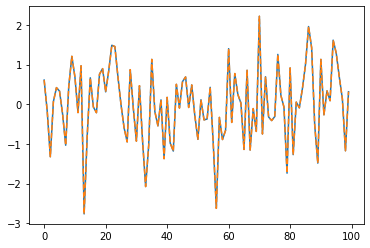

In [19]:
x = np.random.randn(100) 
y = preemphasis(x)
x_rec = deemphasis(y)
plt.plot(x)
plt.plot(x_rec, '--')